## Imports

In [1]:
from pyofss import Domain, System, Gaussian, Fibre, Filter, Splitter, FibrePlotter, Noise, OpenclFibre, OpenclProgramm, Amplifier2LevelModel
from pyofss import temporal_power, spectral_power, lambda_to_nu, nu_to_lambda, multi_plot, single_plot, labels
from pyofss.field import energy, max_peak_params, spectrum_width_params
import numpy as np
import matplotlib as mpl
import matplotlib
import pylab as plt
plt.switch_backend('agg')

from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import time
%matplotlib inline
from pyofss.modules.nonlinearity import calculate_gamma
from pyofss.domain import lambda_to_omega
import os.path
import pyopencl as cl
from pynvml import *


In [2]:
mpl.rcParams['agg.path.chunksize'] = 10000
font = {'family' : 'DejaVu Sans',
        'size'   : 16}

matplotlib.rc('font', **font)

## Check devices availible

In [3]:
platforms = cl.get_platforms() # get a list of platforms
devices = [] # create an empty list to store devices
for platform in platforms: # loop through each platform
    devices.extend(platform.get_devices()) # add the devices from each platform to the list
device_count = len(devices) # get the length of the list
print(devices[0].name)
print(devices[1].name)
print(device_count) # print the number of devices

NVIDIA GeForce RTX 4090
NVIDIA GeForce RTX 4090
2


In [4]:
!gpustat

user-pc                     Sun Oct 29 22:57:11 2023  530.41.03
[0] NVIDIA GeForce RTX 4090 | 58'C,   0 % |   438 / 24564 MB | user(72M) user(12M)
[1] NVIDIA GeForce RTX 4090 | 51'C,  31 % |  2795 / 24564 MB | a.kozmin@g.nsu.ru(2440M) user(4M)


# Choose platform

In [5]:
platform = cl.get_platforms()[0] # get the first platform

## Define amplifier parameters

In [6]:
Pp_0 = 10               # W
N = 4.8
Rr = 80*1e-6            # THz
Tr = 1/Rr 
lamb0 = 1028
length = 8*1e-3
gamma = 5.1
betta_arr = np.array([0, 0, 20])

# Define process parameters

In [7]:
total_steps = 30000
traces = 500
method="rk4ip" # no raman realisation in cl_ss_symmetric for opencl!
method_ocl = "cl_rk4ip"
downsampling = 500

## Define pulse and domain

In [8]:
domain = Domain(samples_per_bit=2**15, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(lamb0))
gaussian = Gaussian(peak_power=600, width=2, C=0, using_fwhm=True)

f_t = interp1d(np.arange(len(domain.t)), domain.t)
interpolated_t = f_t(np.linspace(0, len(domain.t) - 1, downsampling))

f_nu = interp1d(np.arange(len(domain.nu)), domain.nu)
interpolated_nu = f_nu(np.linspace(0, len(domain.nu) - 1, downsampling))

# Helper functions

In [9]:
def check_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Directory: ", dir, " is created!")
        
def get_device_memory_info():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"device name {nvmlDeviceGetName(handle)}")
    print("Total memory: {} MiB".format(info.total >> 20))
    print("Free memory: {} MiB".format(info.free >> 20))
    print("Used memory: {} MiB".format(info.used >> 20))
    nvmlShutdown()
    
def visualise_sys(sys, is_temp):
    flag = "temp" if is_temp else "spec"
    sys.init_df(flag)
    sys.df_type_dict[flag]
    cycle_names = list(set(sys.df_type_dict[flag].index.get_level_values('cycle').values))
    cycle_names.sort()
    cycle_df = sys.df_type_dict[flag].loc[cycle_names[0]]
    fibre_names = list(set(cycle_df.index.get_level_values('fibre').values))
    fibre_names.sort()
    max_value = sys.df_type_dict[flag].values.max()
    min_value = sys.df_type_dict[flag].values.min()
    print("fibre_names:", fibre_names)
    print("cycle_names:", cycle_names)

    fig, ax = plt.subplots(nrows=len(cycle_names), ncols=len(fibre_names), figsize=(50, 10))

    cycle_names = cycle_names
    for i, cycle_name in enumerate(cycle_names):
        cycle_df = sys.df_type_dict[flag].loc[cycle_name]
        fibre_names = list(set(cycle_df.index.get_level_values('fibre').values))
        fibre_names.sort()
        for j, fibre_name in enumerate(fibre_names):
            fibre_df =  sys.df_type_dict[flag].loc[cycle_name].loc[fibre_name]
            z = fibre_df.index.get_level_values('z [mm]').values
            
            h = fibre_df.values.transpose()
            if (len(h) == len(interpolated_t)):
                x = interpolated_t if is_temp else interpolated_nu
            else:
                x = domain.t if is_temp else domain.nu
            
            X, Y = np.meshgrid(z, x)
            cf = ax.pcolormesh(X, Y, h, shading='auto', cmap=plt.cm.get_cmap('plasma'), vmin=min_value, vmax=max_value)
            if is_temp:
                ax.set_ylim(-30, 5)
            else:
                ax.set_ylim(250, 300)
            ax.set_title(f"{cycle_name}, {fibre_name}")

            fig.colorbar(cf, ax=ax)

## 0. Compare Fibre and OpenclFibre modules: with raman, with Yb amplification model

In [10]:
sys0 = System(domain)
sys0.add(gaussian)
sys0.add(Fibre(length=length, method=method, total_steps=total_steps,
            beta=betta_arr, gamma=gamma , self_steepening=False, use_all='hollenbeck', cycle=f'cycle0', traces=traces, Pp_0=Pp_0, N=N, Rr=1/Tr, use_Yb_model=True))
start = time.time()
sys0.run()
stop = time.time()
no_cl_time = stop-start
print(f"Run time without cl is {no_cl_time} s")

platform = cl.get_platforms()[0] # get the first platform
device = platform.get_devices(device_type=cl.device_type.GPU)[0] # get the first GPU device
cl_program = OpenclProgramm(fast_math=True, use_all='hollenbeck', dorf='double', ctx=cl.Context([device]), downsampling=downsampling)
cl_program.set_domain(domain)
sys1 = System(domain)
sys1.add(gaussian)
amplifier = Amplifier2LevelModel(Pp=Pp_0, N=N, Rr=1/Tr, prg=cl_program.prg, queue=cl_program.queue, ctx=cl_program.ctx)
sys1.add(OpenclFibre(cl_programm=cl_program, length=length, total_steps=total_steps,
            beta=betta_arr, gamma=gamma, self_steepening=False, method=method_ocl, cycle=f'cycle0',traces=traces, amplifier=amplifier))
start = time.time()
sys1.run()
stop = time.time()
cl_time = stop-start

print(f"Run time with cl is {cl_time} s")
print(f"cl is faster in {no_cl_time/cl_time} times")

use two level Yb gain model
Using general expression for nonlinearity
gaussian
fibre
Caching linear factor


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:302: RuntimeWarning: invalid value encountered in divide
  self._ratio_s = self.sigma12_s / (self.sigma12_s + self.sigma21_s)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:236: RuntimeWarning: divide by zero encountered in divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (self.T * (self.sigma12_s + self.sigma21_s) * self.rho_s)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:242: SavingWarning: Nothing will be saved - the base fibre directory is not stated!
  warnings.warn("Nothing will be saved - the base fibre directory is not stated!", SavingWarning)


Run time without cl is 288.2255766391754 s
Using compiler optimisations suitable for Nvidia GPUs
use two level Yb gain model
Using general expression for nonlinearity
gaussian
cl_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 824 MiB
Caching linear factor


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:236: RuntimeWarning: divide by zero encountered in divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (self.T * (self.sigma12_s + self.sigma21_s) * self.rho_s)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:302: RuntimeWarning: invalid value encountered in divide
  self._ratio_s = self.sigma12_s / (self.sigma12_s + self.sigma21_s)


Run time with cl is 110.23922610282898 s
cl is faster in 2.6145464443874475 times


### Visualise results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Generating multi_plot...


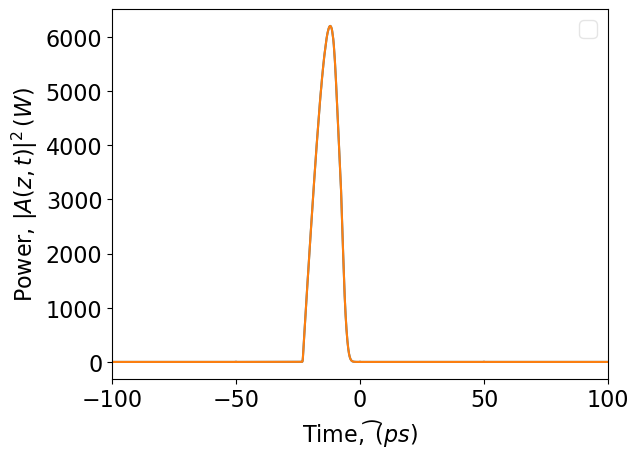

In [11]:
multi_plot(sys1.domain.t, [temporal_power(sys0.field), temporal_power(sys1.field)], ["cpu", "gpu"], labels["t"], labels["P_t"],
            x_range=(-100.0, 100.0), use_fill=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Generating multi_plot...


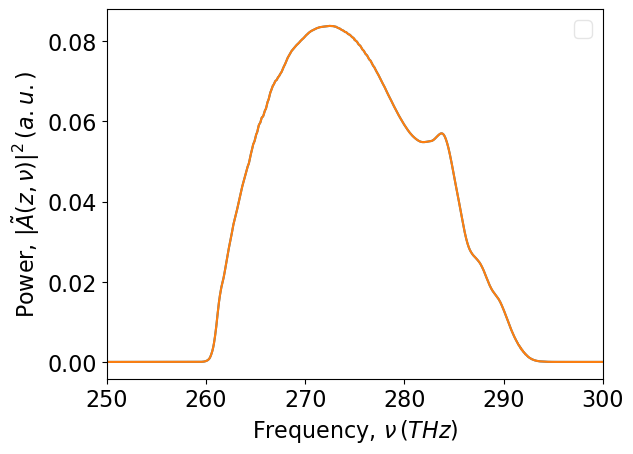

In [12]:
multi_plot(sys1.domain.nu, [spectral_power(sys0.field), spectral_power(sys1.field)], ["cpu", "gpu"], labels["nu"], labels["P_nu"],
            x_range=(250, 300), use_fill=False)

fibre_names: ['fibre']
cycle_names: ['cycle0']


/tmp/ipykernel_401619/3683738731.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cf = ax.pcolormesh(X, Y, h, shading='auto', cmap=plt.cm.get_cmap('plasma'), vmin=min_value, vmax=max_value)


fibre_names: ['cl_fibre']
cycle_names: ['cycle0']


/tmp/ipykernel_401619/3683738731.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cf = ax.pcolormesh(X, Y, h, shading='auto', cmap=plt.cm.get_cmap('plasma'), vmin=min_value, vmax=max_value)


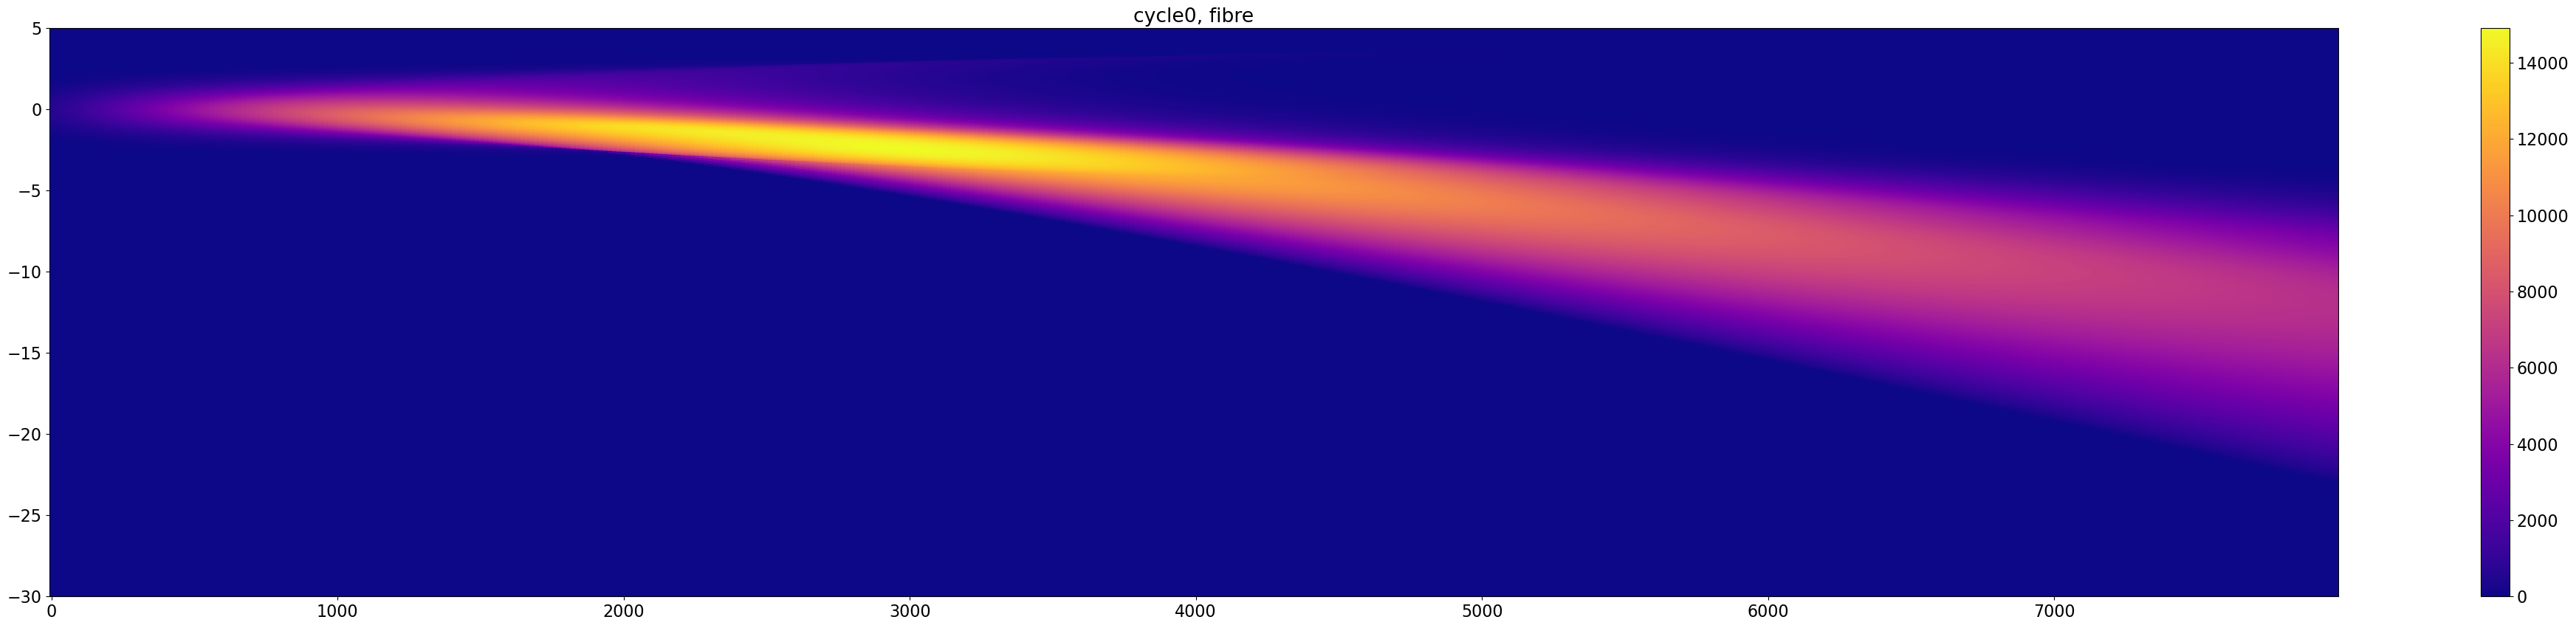

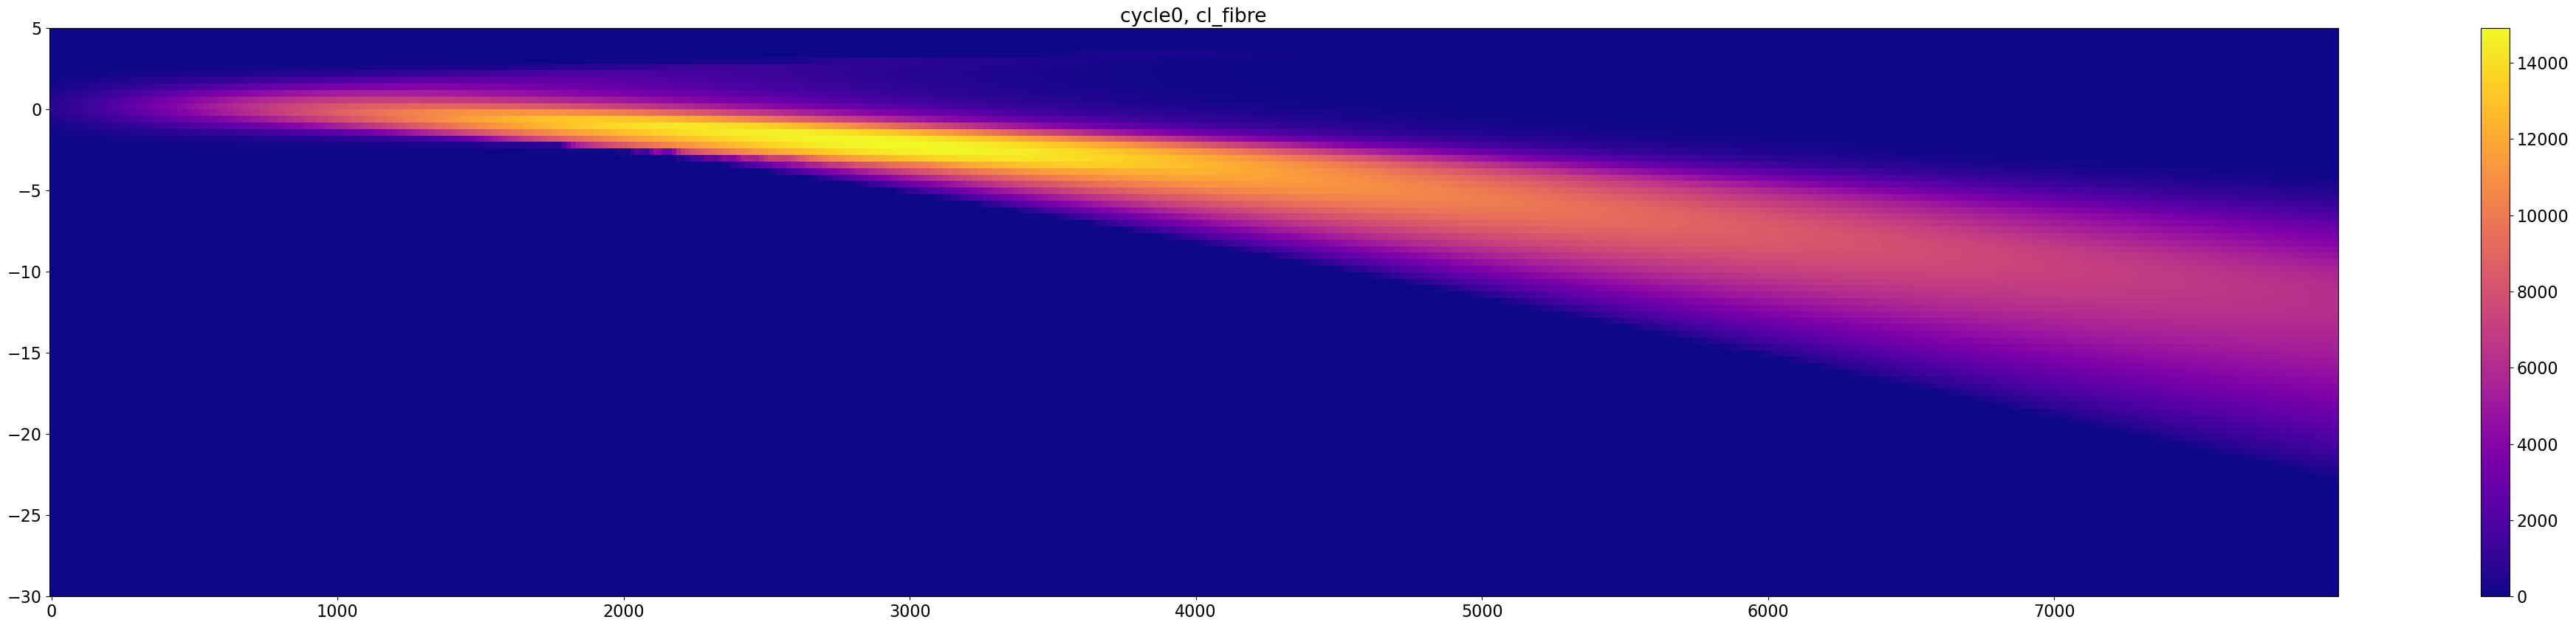

In [13]:
visualise_sys(sys0, True)
visualise_sys(sys1, True)

fibre_names: ['fibre']
cycle_names: ['cycle0']


/tmp/ipykernel_401619/3683738731.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cf = ax.pcolormesh(X, Y, h, shading='auto', cmap=plt.cm.get_cmap('plasma'), vmin=min_value, vmax=max_value)


fibre_names: ['cl_fibre']
cycle_names: ['cycle0']


/tmp/ipykernel_401619/3683738731.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cf = ax.pcolormesh(X, Y, h, shading='auto', cmap=plt.cm.get_cmap('plasma'), vmin=min_value, vmax=max_value)


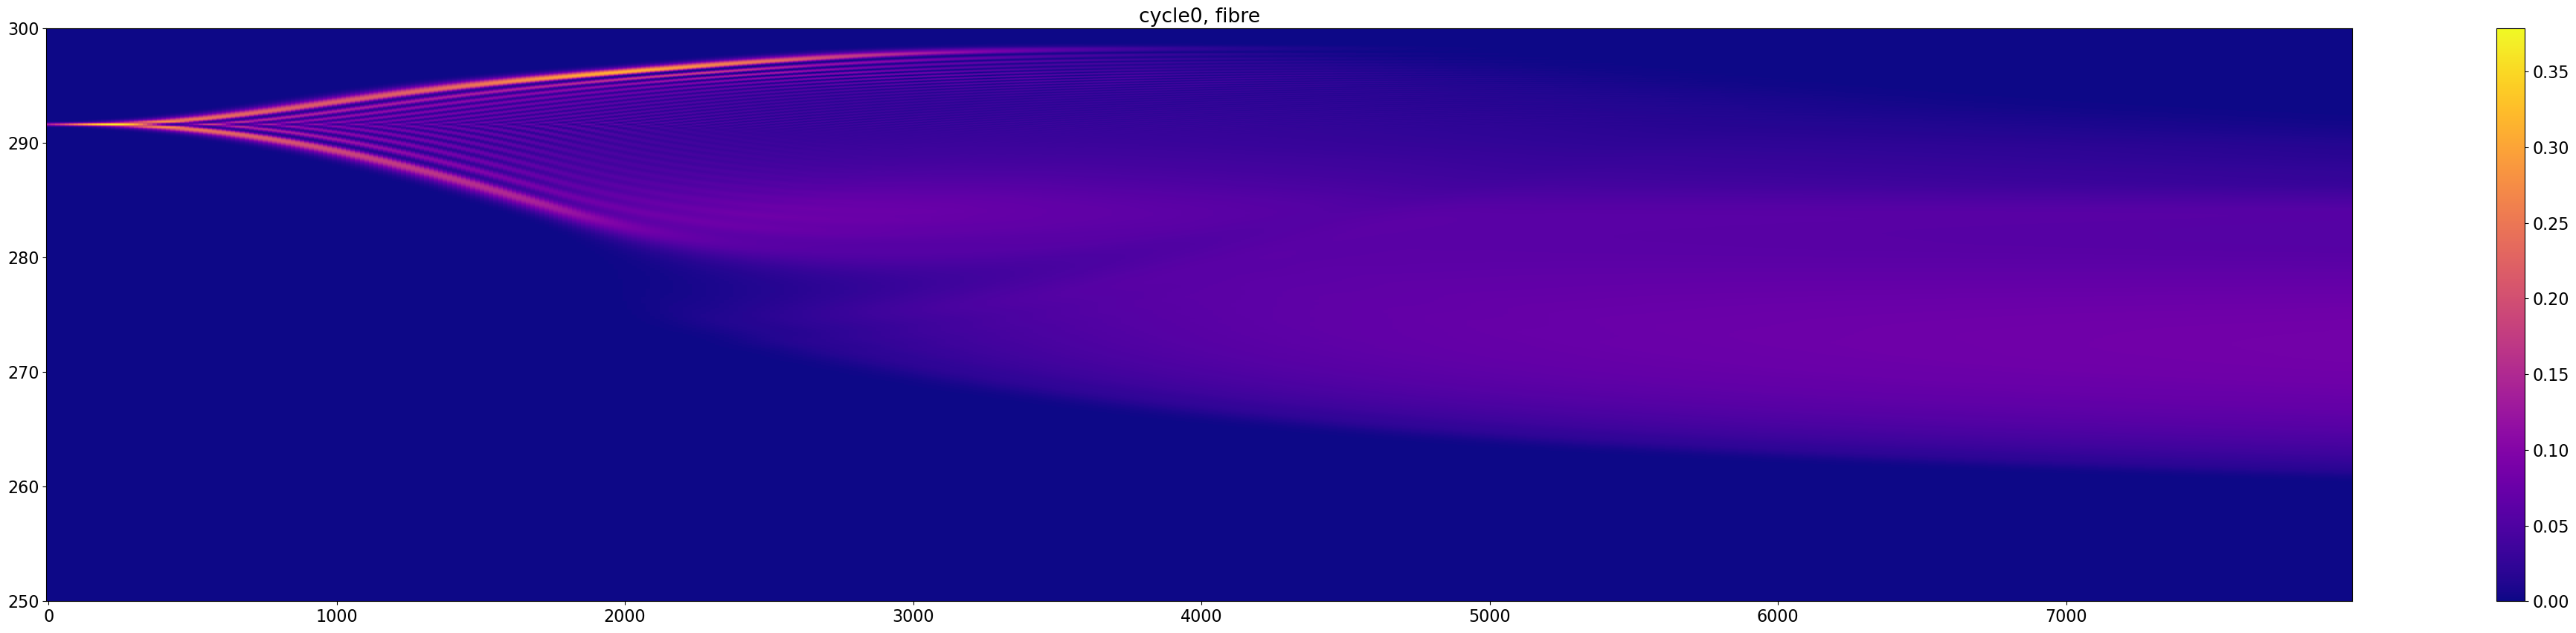

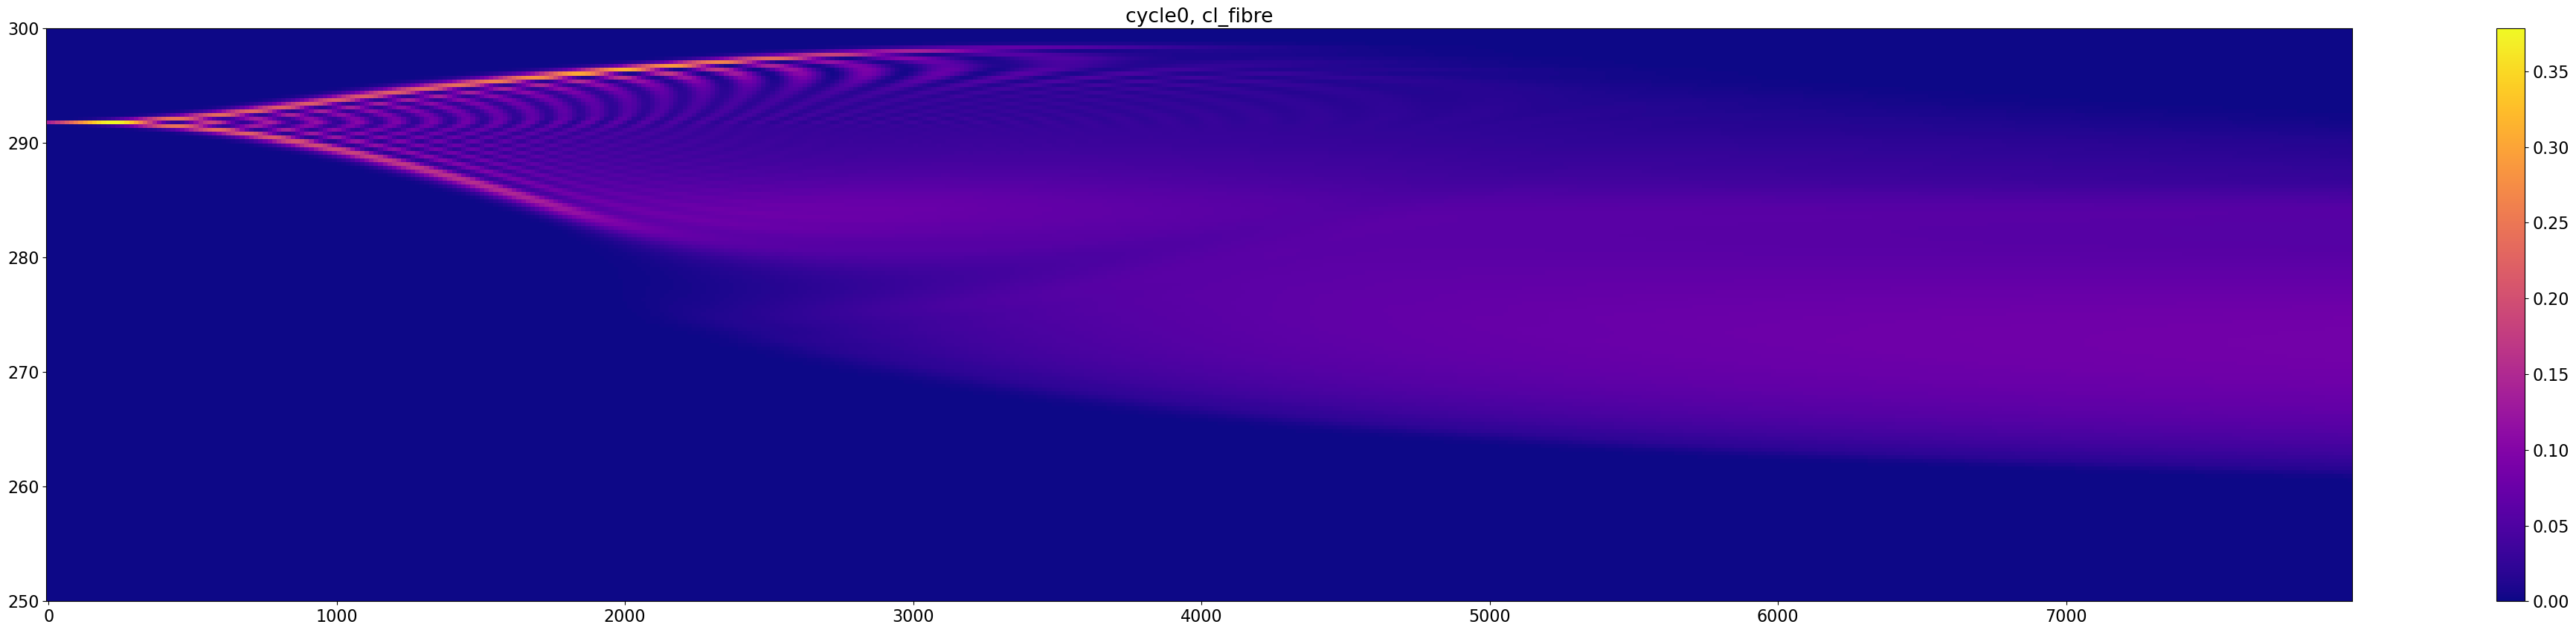

In [14]:
visualise_sys(sys0, False)
visualise_sys(sys1, False)

# Check parameters calculated during propagation

## Check no opencl system

In [15]:
sys0.df_results

max_value     energy   duration  spec_width  \
cycle  fibre z [mm]                                                       
cycle0 fibre 0.266667      601.236774   1.279995   2.000005    0.220641   
             16.266667     678.532629   1.444703   2.000204    0.220632   
             32.266667     761.856597   1.622315   2.000464    0.220684   
             48.266667     851.087934   1.812597   2.000794    0.220817   
             64.266667     946.049969   2.015199   2.001202    0.221058   
...                               ...        ...        ...         ...   
             7920.266667  6272.383473  67.420440  11.119716   21.830118   
             7936.266667  6258.243255  67.435069  11.147953   21.833942   
             7952.266667  6244.182570  67.449560  11.176222   21.838024   
             7968.266667  6230.200795  67.463914  11.204493   21.842322   
             7984.266667  6216.273739  67.478134  11.232754   21.846759   

                            peaks  
cycle  fibre z [mm]                
cycle0 fibre 0.266667     [16384]  
             16.266667    [16384]  
             32.266667    [16384]  
             48.266667    [16384]  
             64.266667    [16384]  
...                           ...  
             7920.266667  [14447]  
             7936.266667  [14442]  
             7952.266667  [14438]  
             7968.266667  [14433]  
             7984.266667  [14426]  

[500 rows x 5 columns]

## Check opencl system (only ebnergy and maxvalue are calclacted)

In [16]:
sys1.df_results

max_value              energy duration  \
cycle  fibre    z [mm]                                                         
cycle0 cl_fibre 0.266667      601.2367736670168  1.2799954187493061      NaN   
                16.266667     678.5326286227568  1.4447025019972937      NaN   
                32.266667     761.8565971445844  1.6223148728494328      NaN   
                48.266667     851.0879337604421  1.8125970118089825      NaN   
                64.266667     946.0499694205364   2.015198540138916      NaN   
...                                         ...                 ...      ...   
                7920.266667   6272.383472481083   67.42044035883954      NaN   
                7936.266667  6258.2432536657425   67.43506873406842      NaN   
                7952.266667   6244.182567661502    67.4495597092648      NaN   
                7968.266667   6230.200792990008   67.46391434695519      NaN   
                7984.266667   6216.273736661421    67.4781337030166      NaN   

                            spec_width peaks  
cycle  fibre    z [mm]                        
cycle0 cl_fibre 0.266667           NaN   NaN  
                16.266667          NaN   NaN  
                32.266667          NaN   NaN  
                48.266667          NaN   NaN  
                64.266667          NaN   NaN  
...                                ...   ...  
                7920.266667        NaN   NaN  
                7936.266667        NaN   NaN  
                7952.266667        NaN   NaN  
                7968.266667        NaN   NaN  
                7984.266667        NaN   NaN  

[500 rows x 5 columns]

### Initialise fields dataframes

In [17]:
sys0.init_df("temp")
sys1.init_df("temp")
sys0.init_df("spec")
sys1.init_df("spec")

In [18]:
sys1.df_type_dict["temp"]

0             1             2    \
cycle  fibre    z [mm]                                                  
cycle0 cl_fibre 0.266667     1.699851e-23  1.631746e-23  1.465766e-23   
                16.266667    6.904211e-20  6.623937e-20  5.943808e-20   
                32.266667    2.949963e-19  2.828343e-19  2.534044e-19   
                48.266667    7.126583e-19  6.827414e-19  6.105405e-19   
                64.266667    1.355998e-18  1.297915e-18  1.158509e-18   
...                                   ...           ...           ...   
                7920.266667  1.064922e-13  1.112853e-13  1.095092e-13   
                7936.266667  1.043805e-13  1.087330e-13  1.083790e-13   
                7952.266667  1.035740e-13  1.045667e-13  1.074552e-13   
                7968.266667  1.014773e-13  1.002367e-13  1.051164e-13   
                7984.266667  9.740370e-14  9.672059e-14  1.000996e-13   

                                      3             4             5    \
cycle  fibre    z [mm]                                                  
cycle0 cl_fibre 0.266667     1.297126e-23  1.210960e-23  1.245941e-23   
                16.266667    5.260957e-20  4.920521e-20  5.077195e-20   
                32.266667    2.241278e-19  2.101595e-19  2.176441e-19   
                48.266667    5.396439e-19  5.075082e-19  5.277403e-19   
                64.266667    1.023495e-18  9.658375e-19  1.008429e-18   
...                                   ...           ...           ...   
                7920.266667  1.150871e-13  1.133162e-13  1.182440e-13   
                7936.266667  1.119056e-13  1.129139e-13  1.143746e-13   
                7952.266667  1.073304e-13  1.124561e-13  1.102778e-13   
                7968.266667  1.032698e-13  1.082743e-13  1.076756e-13   
                7984.266667  1.003379e-13  1.025527e-13  1.048581e-13   

                                      6             7             8    \
cycle  fibre    z [mm]                                                  
cycle0 cl_fibre 0.266667     1.388435e-23  1.578375e-23  1.719531e-23   
                16.266667    5.665286e-20  6.427861e-20  6.991941e-20   
                32.266667    2.430209e-19  2.751478e-19  2.986532e-19   
                48.266667    5.895740e-19  6.657063e-19  7.210112e-19   
                64.266667    1.126845e-18  1.268924e-18  1.371053e-18   
...                                   ...           ...           ...   
                7920.266667  1.182694e-13  1.215788e-13  1.231356e-13   
                7936.266667  1.178742e-13  1.175869e-13  1.224802e-13   
                7952.266667  1.159448e-13  1.144635e-13  1.196955e-13   
                7968.266667  1.112247e-13  1.120180e-13  1.142227e-13   
                7984.266667  1.049963e-13  1.092849e-13  1.086498e-13   

                                      9    ...           490           491  \
cycle  fibre    z [mm]                     ...                               
cycle0 cl_fibre 0.266667     1.731942e-23  ...  1.607856e-23  1.732554e-23   
                16.266667    7.036820e-20  ...  6.545941e-20  7.047865e-20   
                32.266667    3.003399e-19  ...  2.802071e-19  3.014521e-19   
                48.266667    7.247068e-19  ...  6.779879e-19  7.290066e-19   
                64.266667    1.377119e-18  ...  1.292222e-18  1.388697e-18   
...                                   ...  ...           ...           ...   
                7920.266667  1.248903e-13  ...  9.391093e-14  9.434749e-14   
                7936.266667  1.216755e-13  ...  9.070017e-14  9.425028e-14   
                7952.266667  1.188247e-13  ...  8.798614e-14  9.203230e-14   
                7968.266667  1.168875e-13  ...  8.611288e-14  8.783625e-14   
                7984.266667  1.132755e-13  ...  8.396181e-14  8.293283e-14   

                                      492           493           494  \
cycle  fibre    z [mm]                                                  
cycle0 cl_fibre 0.266667   

In [19]:
z_arr = sys1.df_type_dict["temp"].index.get_level_values("z [mm]")

### Check evolution in z range

z current is  7984.266666666666 mm


(-30.0, 30.0)

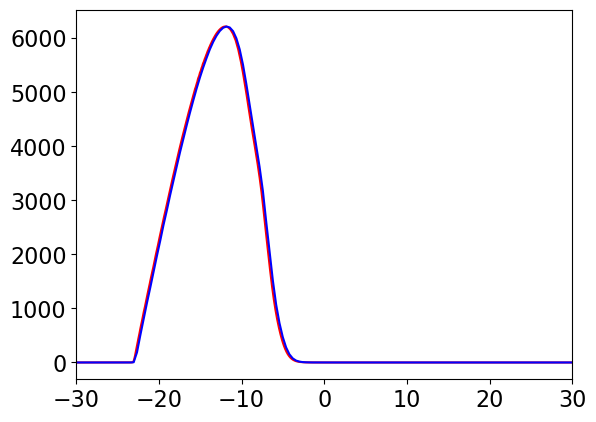

In [20]:
i = -1
print(f"z current is  {z_arr[i]} mm")
plt.plot(domain.t, sys0.df_type_dict["temp"].values[i], color="r")
plt.plot(interpolated_t, sys1.df_type_dict["temp"].values[i], color="b")
plt.xlim(-30, 30)